# Previsão de Preços de Avalanche (AVAX) com LSTM

### 1. Coleta de Dados Históricos (5 anos)

In [2]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 1. Coleta de Dados Históricos (5 anos)
avax = yf.Ticker("AVAX-USD")
avax_data = avax.history(period="5y")

# Usar apenas a coluna 'Close' para previsão
data = avax_data[["Close"]]
data.head()


,Close
Date,
2020-07-13 00:00:00+00:00,4.896294
2020-07-14 00:00:00+00:00,4.986754
2020-09-22 00:00:00+00:00,5.234632
2020-09-23 00:00:00+00:00,4.118469
2020-09-24 00:00:00+00:00,4.566561


### 2. Normalização dos Dados

In [3]:

# 2. Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data[:5]


array([[0.01511973],
       [0.01580699],
       [0.0176902 ],
       [0.00921033],
       [0.01261464]])

### 3. Criar Sequências para o Modelo LSTM

In [4]:

# 3. Criar as sequências para o modelo LSTM
sequence_length = 60  # Usaremos 60 dias de histórico para prever o próximo dia
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length : i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Redimensionar X para ter a forma [amostras, sequência temporal, número de features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X.shape, y.shape


((1400, 60, 1), (1400,))

### 4. Divisão dos Dados (80% treino, 20% teste)

In [5]:

# 4. Divisão dos Dados (80% treino, 20% teste)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape


((1120, 60, 1), (280, 60, 1))

### 5. Construção do Modelo LSTM

In [10]:

# 5. Construção do Modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")

# Treinamento do modelo
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)


Epoch 1/200


/Users/luandemello/Workspace/2024/Atividade-Python/pondBitcoin/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0287
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0027
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 11/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 12/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 13/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
Epoch 14/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 15/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
E

### 6. Fazer Previsões

In [11]:

# 6. Fazer Previsões
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# Previsão dos próximos 30 dias
last_sequence = X_test[-1]  # Última sequência do conjunto de teste
predictions = []

for _ in range(30):
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred)[-sequence_length:]
    last_sequence = last_sequence.reshape(sequence_length, 1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

predicted_prices[:5]


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

array([[38.435955],
       [38.66194 ],
       [39.112915],
       [41.23877 ],
       [40.013092]], dtype=float32)

### 7. Cálculo das Métricas do Modelo

In [13]:

# Preços reais de teste para comparação
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Cálculo das Métricas do Modelo
mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Squared Error (MSE): 3.49
Root Mean Squared Error (RMSE): 1.87
Mean Absolute Error (MAE): 1.35


### 8. Plotar o Gráfico de Previsão vs Real, incluindo os próximos 30 dias

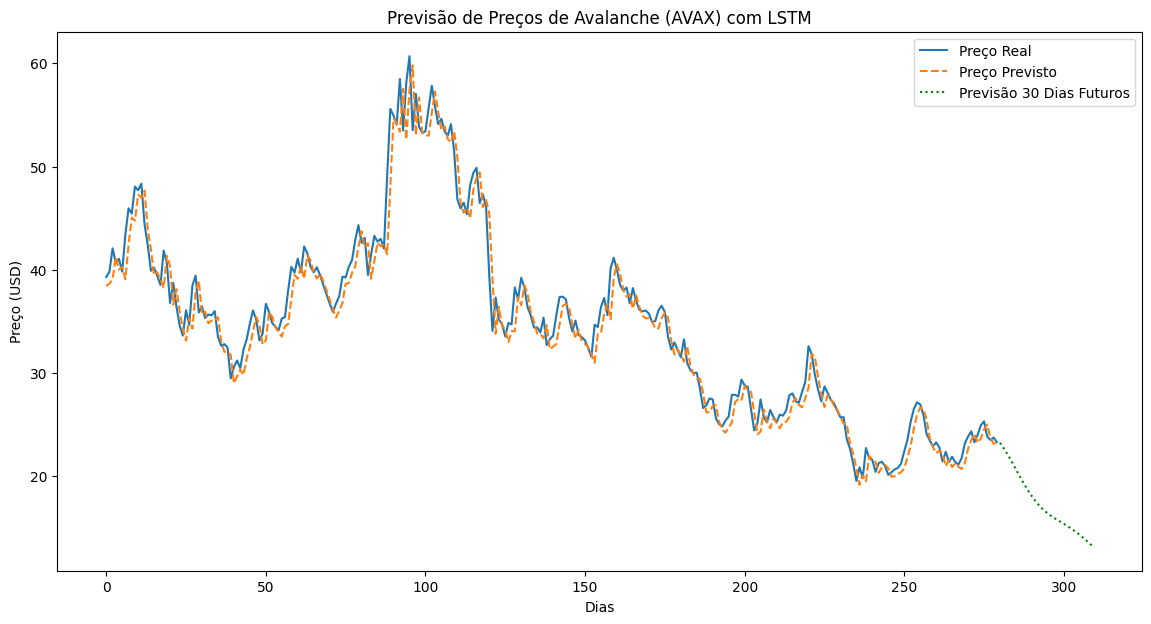

In [14]:

# 8. Plotar o Gráfico de Previsão vs Real, incluindo os próximos 30 dias
plt.figure(figsize=(14, 7))
plt.plot(real_prices, label="Preço Real")
plt.plot(predicted_prices, label="Preço Previsto", linestyle="dashed")

# Adicionar as previsões dos próximos 30 dias ao gráfico
future_days = np.arange(len(real_prices), len(real_prices) + 30)
plt.plot(
    future_days,
    predictions,
    label="Previsão 30 Dias Futuros",
    linestyle="dotted",
    color="green",
)

plt.title("Previsão de Preços de Avalanche (AVAX) com LSTM")
plt.xlabel("Dias")
plt.ylabel("Preço (USD)")
plt.legend()
plt.show()
